# Batch Normalization


When a network learns its parametrization it applies an optimization algorithm on a given loss function.
A problem which occurs when training deep neural networks is a phenomena called _internal covariate shift_.
When the features passed from one layer to the next changes due to a change in the parameters, it affects all the deeper layers in the network, and it needs to relearn its parameters to account for this shift in covariates.
[**Sergey Ioffe and Christian Szegedy**](https://arxiv.org/pdf/1502.03167v3.pdf) proposed a method to account for this *internal covariate shift*, called *batch normazation*.

We will in this numerical example present the algorithm of batch normalization and how it is implemented in a neural network, and show some results from the initial paper.
We will also create our own code that will apply this algorithm to mini-batches on a given kernel and activiation function. 

### Internal Covariance Shift

Given a loss function, the parameters of a network $\theta$ is found from a optmization method 

\begin{equation*}
\theta = \underset{\theta}{\mathrm{argmin}}\frac{1}{N}\sum\limits_{i=1}^N \mathcal{l}(x_i,\theta),
\end{equation*}
where $x_i$ is the input data that the network is trained on and $\mathcal{l}$ is the loss function that is to be minimized.

Assume $\alpha_1$ and $\alpha_2$ to be two arbitrary transformations applied in order to calculate the optimization loss during training.

\begin{equation*}
\mathcal{l} = \alpha_2(\alpha_1(x;\theta_1); \theta),
\end{equation*}

where $\theta_1$ and $\theta_2$ are the parametrizations of each layer, which are to be learned.
The transformations $\alpha_1$ and $\alpha_2$ are interpreted as two consecutive _sub-components_ of the neural network.
This means that we have values outputed from the first layer $z = \alpha_1(x; \theta_1)$, that will change when the parameters $\theta_1$ are learned/changed. This means that the second layer, $ y = \alpha_2(z;\theta_2)$, will be affected by this distributional change in the outputs from the first layer and the network will learn slower than if the second layer wasn't affected by this change. Here we can apply batch normalization to the outputs of the first layer to fixate the inputs to the second layer such that it is not affected by the training of other layers. 



### Normalization

Normalizing each layer using the whole dataset is very costly and is not differentiable everywhere.
To account for this, batch-normalization has been implemented using two simplifications.
The first one being that normalization is done along the different dimensions of the layers.
This means that the input normalization is applied independetly for red, green and blue channels for the original input, and in the interior of the network, you should normalize each filter channel independently.
Which means that given a layer of channel depth $d$, the input $\mathbf{x} = (\mathbf{x}^{(1)},\mathbf{x}^{(2)},\dots,\mathbf{x}^{(d)})$ would be normalized by

\begin{equation*}
\hat{\mathbf{x}}^{(k)} = \frac{\mathbf{x}^{(k)} - \mathrm{E}[\mathbf{x}^{(k)}]}{\sqrt{\mathrm{Var}[\mathbf{x}^{(k)}]}}
\end{equation*}

If we assume an original normal distribution of the input layer to be normal distributed, $\mathcal{N}(\mu, \sigma^2)$, the normalized output is standard normal distributed, $\mathcal{N}(0, 1)$.
Depending on the activation functions in use by the neural network, such a distribution is not always optimal, since the activation function may "squeeze" the input in this domain.
It is therefore important to allow an additional parametrization that scales and shifts the normalization output into the domain most suitable for the given activation function in the upcoming layer.
To do this scale and shift parameters are introduced to the transformations that are learned along with the other model parameters. This results in the input to the layer in the neural network

\begin{equation*}
\mathbf{y}^{(k)} = \hat{\mathbf{x}}^{(k)}\gamma^{(k)} + \beta^{(k)},
\end{equation*}

which means that the distribution of the normalized output lie in the distribution $\mathcal{N}[\beta^{(k)},\gamma^{(k)}]$.
Also of note here is that the transformation  would represent the identity transform if the $\beta^{(k)} = \mathrm{E}[\mathbf{x}^{(k)}]$ and $\gamma^{(k)} = \mathrm{Var}[\mathbf{x}^{(k)}]$.

A second simplification is to use the mean and variance of the batch for normalization. This makes the normalization able to participate fully in the backpropagation. We split the data into mini-batches $\mathcal{B}^{(k)} = \{x_1^{(k)},\dots,x_m^{(k)}\}$ of size $m$. Then the batch-normalization transformation becomes

\begin{equation*}
\mathrm{BN}:x_{1\dots m}^{(k)} \rightarrow \hat{x}_{1\dots m}^{(k)} \rightarrow y_{1\dots m}^{(k)},
\end{equation*}

which is summed up in the following algorithm which is the same algorithm included in the paper by <a href = "https://arxiv.org/pdf/1502.03167v3.pdf"> **Sergey Ioffe and Christian Szegedy**</a> .

\begin{equation*}
\boxed{\begin{array}{ll}
    \textbf{Input:} & \textrm{Values of $x^{(k)}$ over a mini-batch:} \enspace \mathcal{B} = \{x_{1,\dots,m}\}^{(k)};\\
     & \textrm{Parameters to be learned:} \gamma^{(k)}, \beta^{(k)} \\ 
     \textbf{Output:} & \{y_i^{(k)} = \mathrm{BN}_{\gamma^{(k)},\beta^{(k)}}(x^{(k)}_i)\} \\
\end{array}\\
\begin{array}{lr}
    \enspace \mu_{\mathcal{B}^{(k)}} = \frac{1}{m}\sum\limits_{i=1}^m x_i^{(k)} & \textrm{mini-batch mean} \\
    \enspace \sigma_{\mathcal{B}^{(k)}}^2 = \frac{1}{m}\sum\limits_{i=1}^m (x_i^{(k)} - \mu_{\mathcal{B}^{(k)}})^2 & \textrm{mini-batch variance}\\
    \enspace \hat{x}_i^{(k)} = \frac{x_i^{(k)} - \mu_{\mathcal{B}^{(k)}}}{\sqrt{\sigma_{\mathcal{B}^{(k)}}^2 + \epsilon}} & \textrm{normalize} \\ 
    \enspace y_i^{(k)} = \gamma^{(k)} \hat{x}_i^{(k)} + \beta^{(k)} \equiv \mathrm{BN}_{\gamma^{(k)},\beta^{(k)}}(x_i^{(k)}) & \textrm{scale and shift}
\end{array}}\\
\textbf{Algorithm 1:}\textrm{ Batch Normalizing Transform, applied to} \\ \textrm{activation } x \textrm{ over a mini-batch.}
\end{equation*}

The batch-normalization can be viewed as a sub-network within the bigger network. The $\beta$ and $\gamma$ parameters are learned through the training and the gradient of the loss $\mathcal{l}$ of these parameters are found with the equations

\begin{equation*}
\begin{array}{rcl}
    \frac{\partial\mathcal{l}}{\partial\hat{x}_i} & = & \frac{\partial\mathcal{l}}{\partial y_i} \gamma \\
    \frac{\partial\mathcal{l}}{\partial\sigma_\mathcal{B}^2} & = & \sum_{i = 1}^m \frac{\partial\mathcal{l}}{\partial\hat{x}_i}\frac{-1}{2}(\sigma_\mathcal{B}^2 + \epsilon)^{-3/2} \\
    \frac{\partial\mathcal{l}}{\partial\mu_\mathcal{B}} & = & \left( \sum_{i = 1}^m \frac{\partial\mathcal{l}}{\partial\hat{x}_i} \frac{-1}{\sqrt{\sigma_\mathcal{B}^2 + \epsilon}}\right) + \frac{\partial\mathcal{l}}{\partial\sigma_\mathcal{B}^2} \frac{\sum_{i = 1}^m -2(x_i - \mu_\mathcal{B})}{m} \\
    \frac{\partial\mathcal{l}}{\partial x_i} & = & \frac{\partial\mathcal{l}}{\partial\hat{x}_i} \frac{1}{\sqrt{\sigma_\mathcal{B}^2 + \epsilon}} + \frac{\partial\mathcal{l}}{\partial\sigma_\mathcal{B}^2}\frac{2(x_i - \mu_\mathcal{B})}{m} + \frac{\partial\mathcal{l}}{\partial\mu_\mathcal{B}}\frac{1}{m} \\
    \frac{\partial\mathcal{l}}{\partial\gamma} & = & \sum_{i = 1}^m \frac{\partial\mathcal{l}}{\partial y_i} \hat{x}_i \\
    \frac{\partial\mathcal{l}}{\partial \beta} & = & \sum_{i = 1}^m \frac{\partial\mathcal{l}}{\partial y_i}.
\end{array}
\end{equation*}

The joint distribution of the $\hat{x}$ are assumed to change during training, but with the transformation the distributional change won't be as large as prior to the batch-normalization and thus result in faster training of the neural network. It is important to note that during training a running average and running variance is used to calculate the mini-batch statistics. This will stabalize the mini-batch statistics and the trainable parameters in the sub-network. This running statistics is then applied during validation/testing.

<a href = "https://arxiv.org/pdf/1502.03167v3.pdf"> **Sergey Ioffe and Christian Szegedy**</a> created a network with three fully-connected layers and trained on the **MNIST** dataset and they presented their results with the figure shown below. 

![Normalization](https://i.imgur.com/VmjHe4o.png)

**a)** is the accuracy of the network during training. **b)** and **c)** shows the distributional change of one layer during training, given in {15, 50, 85}th percentiles. 



## Visualization of Internal Covariance shift

Assume that we have a color input image: red, green, and blue channels, and a hidden layer with 3 independent kernels.
These kernels are very simple, they scale each color channel independently, scaling by a factor of $\left(\frac{1}{2}\right)^{(\textrm{epoch number})}$.
This means that if we train the network indefinitely, we will approach three zero kernels.
We will ignore the remaining part of the network, solely focusing on how the first hidden layer transforms the input.

First we import the required packages.


In [1]:
import os # to get directories
from PIL import Image # to open images and resize
import matplotlib.pyplot as plt # plotting
import numpy as np 
import cv2 # to create distributions of rgb
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

The **load_batch()** function will load a batch from directory and resize it to the required size. 

In [2]:
def load_batch(batch_size,img_size,last_it):
    data_dir = '../numerical_examples/data/small/train/dogs/'
    data_files = os.listdir(data_dir)
    array = np.array(
        [
            np.array(Image.open(f'{data_dir}/{data_files[i]}').resize((img_size, img_size), Image.ANTIALIAS))
            for i
            in range(last_it,batch_size+last_it)
        ]
    )
    return array

The **batch_normalization2d()** will apply batch normalization to the network by **Algorithm 1**. The noise term is set to $\epsilon = 10^{-5}$.

In [3]:
def batch_normalization2d(array,gamma,beta,batch_size,batch_norm, eps=1e-5):
    assert array.ndim == batch_size
    if batch_norm:
        mean = array.mean(axis=(0,1,2))
        std = array.std(axis=(0,1,2))
        array = (array - mean)/np.sqrt(std**2 + eps)
        array = array*gamma + beta
    return array

The **visualize_batch()** function will plot the distribution of the different channels for a entire batch.

In [4]:
def visualize_batch(array,batch_num,epoch):
    colors = ("b", "g", "r")
    fig = plt.figure(figsize = (20,5))
    plt.title("Batch: {} ;  Epoch: {}".format(batch_num+1,epoch+1))
    plt.axis("off")
    for i, img in enumerate(array):
        img = np.float32(img)
        chans = cv2.split(img)
        features = []
        for (chan, color) in zip(chans, colors):
            hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
            features.extend(hist)
            ax = fig.add_subplot(1,4,i+1)
            ax.plot(hist, color = color)
            plt.xlim([0, 256])
    plt.pause(0.5)

The **output_layer()** function applies some simple kernel to the different channels. We simply choose a magnitude **move** that represent the training step.

In [5]:
def output_layer(array,move,batch_size):
    assert array.ndim == batch_size
    array = array*move
    return array

The **network_flow()** functions controls the flow of the network. Which means every epoch of training and the iteration through batches. If we want batch_normalization to be used in the first hidden layer of the network we set **batch_norm = True**. We have also fixed $\gamma = 10$ and $\beta = 14$ for simplicity, however generally in batch normalization these are trained.

In [6]:
def network_flow(img_size,batch_size,n_img,n_epochs,batch_norm = True):
    for epoch in range(n_epochs):
        num_batches = n_img//batch_size
        last_batch_num = 0
        gamma = 10
        beta = 14
        for i in range(num_batches):
            batch = load_batch(batch_size,img_size,last_batch_num)
            output_batch = output_layer(batch,1/(epoch+1),batch_size)
            normalized_batch = batch_normalization2d(output_batch,gamma,beta,batch_size,batch_norm)
            visualize_batch(normalized_batch,i,epoch)
            last_batch_num += batch_size
    return
    



We will now display what happens in a neural network when batch normalization is not used. We will use our toy network and pretend like the first layer is moving towards its optimum weights. Then we will look at the output of this layer and visualize how the different channel distributions are moved when being trained. We will "train" for three epochs with a batch size of 4 images from a dogs and cats dataset. Below a example image from this dataset is presented.

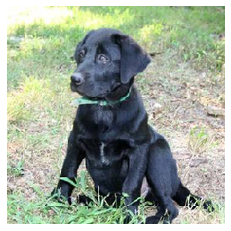

In [7]:
tmp_img = load_batch(4,224,0)
plt.imshow(tmp_img[0,:,:,:]);
plt.axis("off");

## Without Batch Normalization

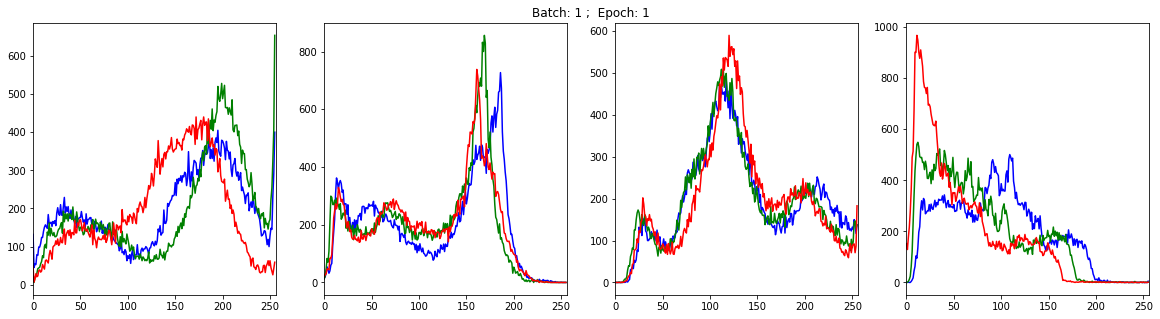

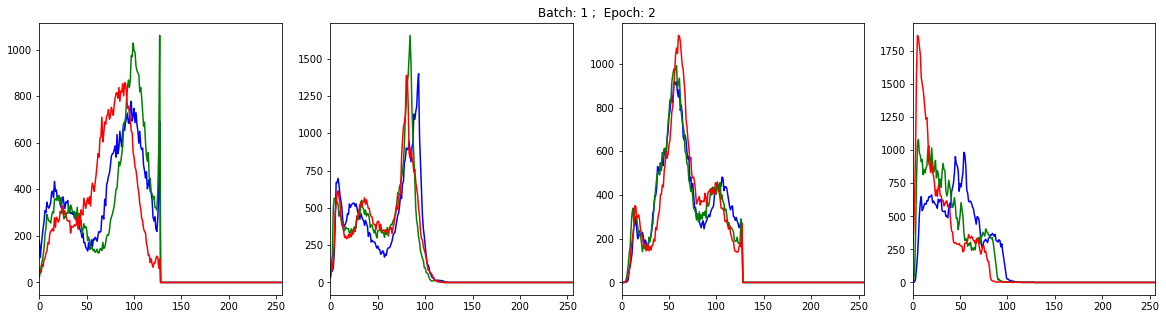

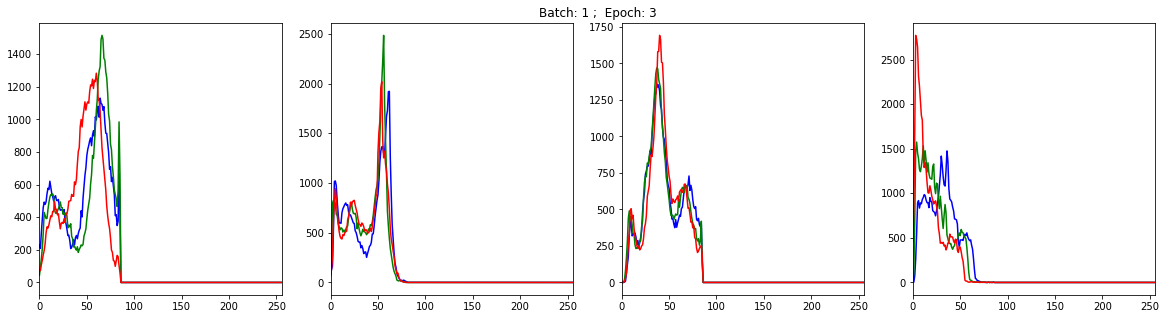

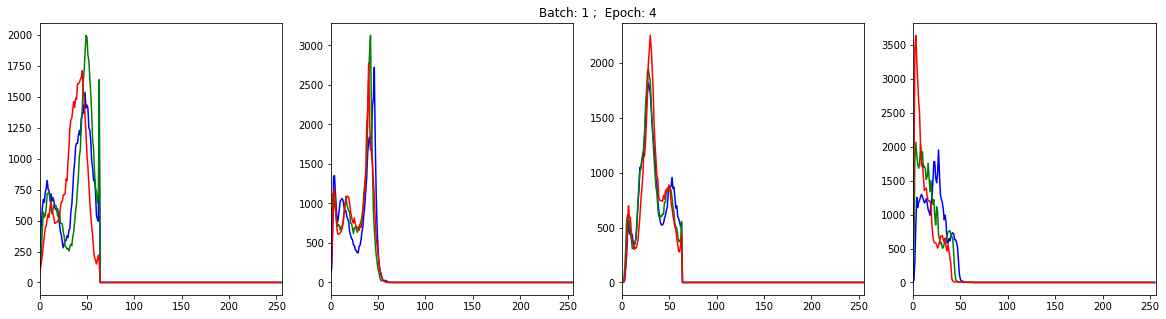

In [8]:
# one batch, three epochs, without bn
network_flow(img_size = 224,batch_size = 4,n_img = 4,n_epochs = 4, batch_norm = False)

We can now clearly observe the internal covariance shift.

## With Batch Normalization

Let's now try to apply batch normalization after the first layer.
We will use $\gamma = 10$ and $\beta = 14$ as previously mentioned.
As figure below clearly presents there is no distributional change in the ouput of the first layer, even thought the weights of the first layer is changing. 

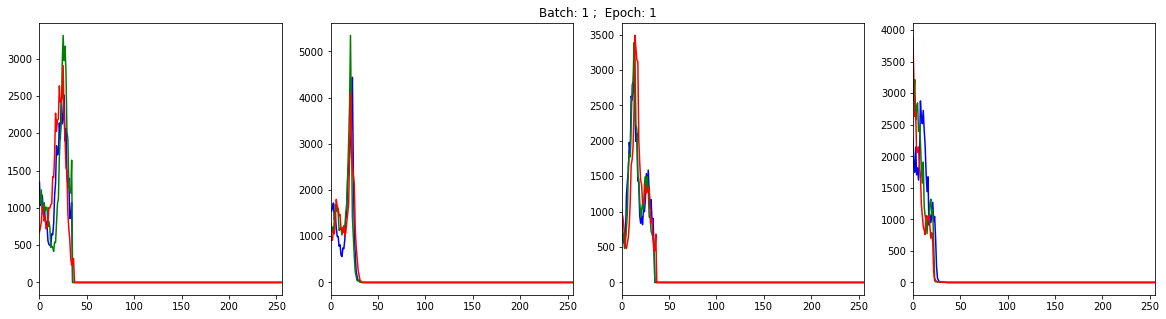

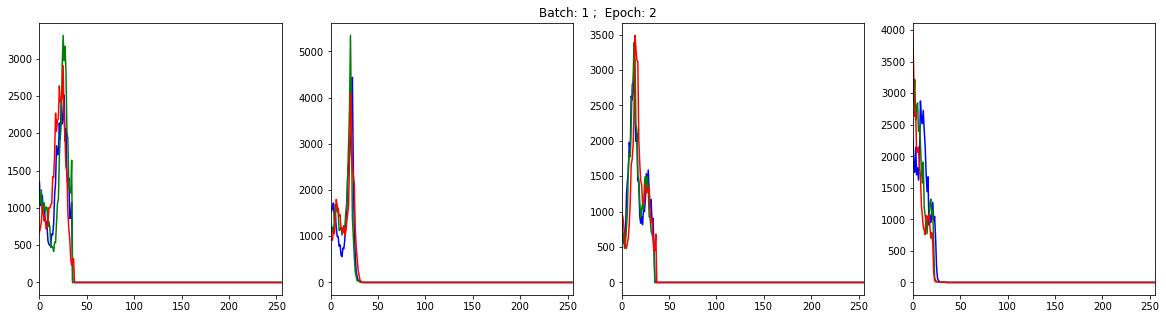

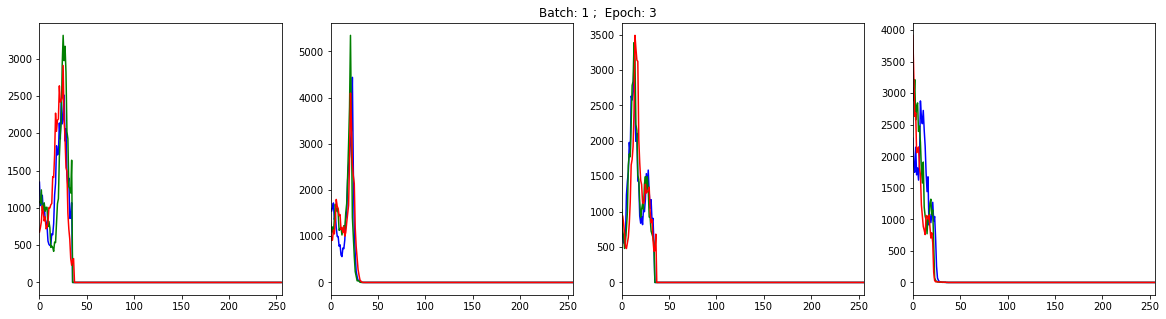

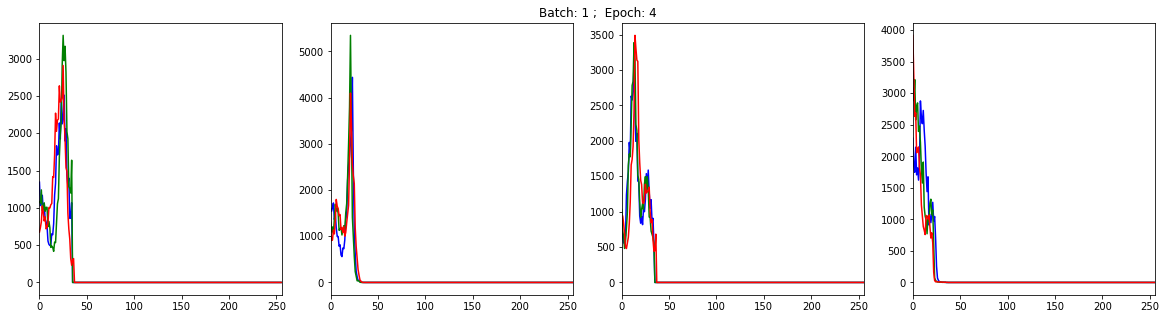

In [9]:
network_flow(img_size = 224,batch_size = 4,n_img = 4,n_epochs = 4,batch_norm=True)

Since the distributional properties of the resulting output features do not change, a network would be able to train faster.
Keep in mind that this is a dummy problem, and in reality, the shape of the output distributions may still change, but the mean and variance would stay the same due to the batch normalization.